In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

import tensorflow as tf
import tensorflow_hub

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img

In [2]:
train_dir = '../data/training_images_labeled/'

batch_size = 32
target_size = (224, 224)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                rotation_range=0.2,
                                                                # shear_range=0.2,
                                                                # zoom_range=0.2,
                                                                validation_split=0.2)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        class_mode='categorical',
        color_mode='rgb',
        target_size=target_size,
        batch_size=batch_size,
        subset='training')

val_generator = train_datagen.flow_from_directory(
        train_dir,
        class_mode='categorical',
        color_mode='rgb',
        target_size=target_size,
        batch_size=batch_size,
        subset='validation',
        shuffle=False)

Found 2605 images belonging to 2 classes.
Found 651 images belonging to 2 classes.


In [3]:
base_model = tf.keras.applications.resnet_v2.ResNet50V2(weights='imagenet',include_top=False,input_shape=(224, 224, 3))
base_model.trainable = False

In [4]:
i = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(64, activation='relu')(i)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input,outputs=x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
AUC = tf.keras.metrics.AUC()
model.compile(loss = 'categorical_crossentropy', optimizer=optimizer,metrics=['accuracy','categorical_accuracy',precision,recall,AUC])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=1, restore_best_weights=True, verbose=0)
reduceLRonplateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=0)
checkpoint = tf.keras.callbacks.ModelCheckpoint('../esha/R_CNN',save_format='tf', monitor='val_accuracy', save_best_only=True,verbose=0)

tf.keras.backend.clear_session()

history = model.fit(train_generator,validation_data = val_generator,epochs=100, callbacks=[early_stopping,reduceLRonplateau,checkpoint],verbose=1)

Epoch 1/100
82/82 [==============================] - ETA: 0s - loss: 3.1348 - accuracy: 0.7459 - categorical_accuracy: 0.7459 - precision: 0.7459 - recall: 0.7459 - auc: 0.7887

INFO:tensorflow:Assets written to: ../esha\R_CNN\assets


INFO:tensorflow:Assets written to: ../esha\R_CNN\assets


82/82 [==============================] - 154s 2s/step - loss: 3.1348 - accuracy: 0.7459 - categorical_accuracy: 0.7459 - precision: 0.7459 - recall: 0.7459 - auc: 0.7887 - val_loss: 0.5538 - val_accuracy: 0.7189 - val_categorical_accuracy: 0.7189 - val_precision: 0.7189 - val_recall: 0.7189 - val_auc: 0.7777 - lr: 0.0010
Epoch 2/100
82/82 [==============================] - ETA: 0s - loss: 0.3845 - accuracy: 0.8253 - categorical_accuracy: 0.8253 - precision: 0.8253 - recall: 0.8253 - auc: 0.9095

INFO:tensorflow:Assets written to: ../esha\R_CNN\assets


INFO:tensorflow:Assets written to: ../esha\R_CNN\assets


82/82 [==============================] - 152s 2s/step - loss: 0.3845 - accuracy: 0.8253 - categorical_accuracy: 0.8253 - precision: 0.8253 - recall: 0.8253 - auc: 0.9095 - val_loss: 0.5891 - val_accuracy: 0.7204 - val_categorical_accuracy: 0.7204 - val_precision: 0.7204 - val_recall: 0.7204 - val_auc: 0.7806 - lr: 0.0010


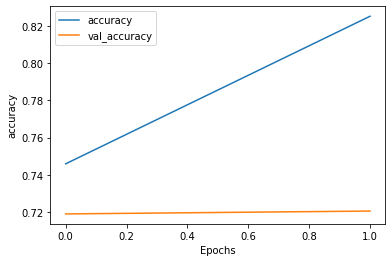

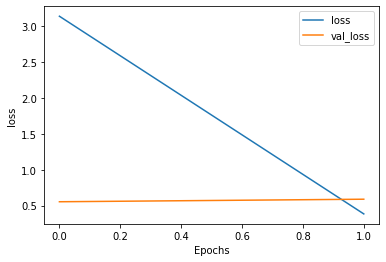

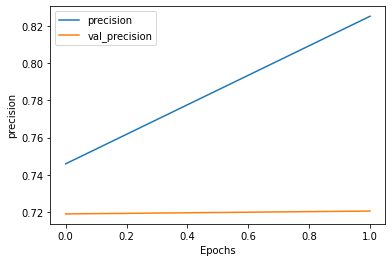

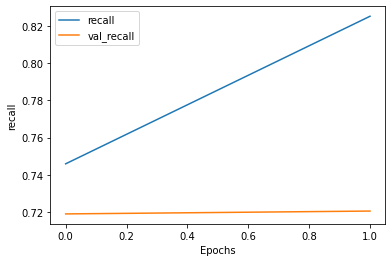

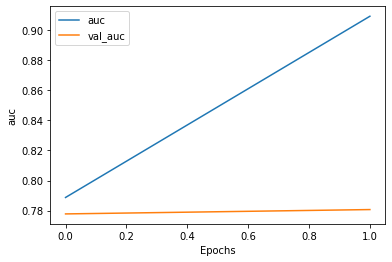

In [6]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")
plot_graphs(history, "precision")
plot_graphs(history, "recall")
plot_graphs(history, "auc")

In [7]:
model_best = tf.keras.models.load_model('../esha/R_CNN')